## David Gamaliel Arcos Bravo
### Examen Optimización y Metaheurísticas 2do Parcial

## Librerias

In [15]:
from random import random, shuffle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, ArtistAnimation
import matplotlib.gridspec as gridspec
from IPython import display
import sympy as sp
import matplotlib._color_data as mcd

## Objeto punto

In [2]:
class Point:
    
    def __init__(self, x, y, id):
        self.ID = id
        self.X = x
        self.Y = y

    def __str__(self):
        return "Point(%s,%s,%s)"%(self.ID,self.X, self.Y) 

    def distance(self, p):
        dx = self.X - p.X
        dy = self.Y - p.Y
        return np.hypot(dx, dy)

## Save Files

In [3]:
def solToFile(value, dist, idx='best'):
    f = open(f"out-iteracion-{idx}.txt", 'w')
    
    centros = [ dist[i][0].ID for i in range(len(dist))  ]
    f.write("Centros: "+str(centros)+'\n\n')
    
    sumas = [ 0 for _ in range(len(dist)) ]
    for i in range(len(dist)):
        pts = []
        centro = dist[i][0]
        for p in dist[i]:
            sumas[i] += centro.distance(p)
            pts.append(p.ID)
        f.write(f"Puntos centro {i+1}: "+str(pts)+'\n')
    f.write('\n')
    
    for i in range(len(dist)):
        f.write(f"Suma conjunto {i+1}: "+str(sumas[i])+'\n')
    f.write('\n')
    
    f.write(f"Suma total : "+str(value)+'\n')
    f.write('\n')
    
    f.close()
    return

## Recocido Simulado

In [1]:
class RecocidoSimulado:
    
    def __init__(self, _n_centros=0, _n_puntos=0, _iteraciones=2000, _T_ini=2000, _T_minima = 0, _show=False):
        self.it = _iteraciones
        self.T_ini = _T_ini
        self.T_minima = _T_minima
        self.show = _show
        self.n_centros = _n_centros
        self.n_puntos = _n_puntos
        self.pts = []
        self.a = 1.0
        self.b = 0.0
        return
    
    def setProbabilities(self, _a=1.0, _b=0.0):
        self.a = _a
        self.b = _b
        return
    
    ## Solo en el formato especifico del profe
    def readDocument(self, fileName="hola.txt"):
        f = open(fileName, "r")
        self.n_puntos, self.n_centros = map(int, f.readline().split())
        f.readline()
        for i in range(self.n_puntos):
            _id, x, y = map(int, f.readline().split())
            p = Point(x,y,_id)
            self.pts.append(p)
        f.close()
        return
    
    def fObjetivo(self, sol):
        total = 0
        for i in range(self.n_centros):
            if len(sol[i]) == 0: continue
            centro = sol[i][0]
            for p in sol[i]:
                total += centro.distance(p)
        return total
    
    def newTemp( self, Tmp):
        lr_aum = 1.01
        lr_dec = 0.99
        # 15% de probabilidad de aumentar la temperatura
        if np.random.uniform() < 0.1: Tmp = Tmp * lr_aum
        # 85% de probabilidad de disminuir la temperatura
        else:                          Tmp = Tmp * lr_dec
        return Tmp
    
    def getRandomVector(self):
        vec = [ [] for _ in range(self.n_centros) ]
        pts = self.pts
        shuffle(pts)
        # Asignar puntos
        for i, p in enumerate(pts[:self.n_centros]):
            vec[i].append(p)
        for p in pts[self.n_centros:]:
            dist = vec[0][0].distance(p)
            idx = 0
            for i in range(len(vec)):
                centro = vec[i][0]
                if centro.distance(p) < dist: 
                    dist, idx = centro.distance(p), i
            vec[idx].append(p)
            
        return vec
    
    def shuffleRandomCenter(self, vec, index = None):
        for index in len(vec):
            idx = 0
            centro = vec[index][0]
            ant = -1
            for i, center in enumerate(vec[index]):
                suma = 0
                for p in vec[index]:
                    suma += center.distance(p)
                if ant == -1: ant = suma
                elif suma < ant: 
                    ant, centro, idx = suma, center, i
            vec[index][idx], vec[index][0] = vec[index][0], vec[index][idx]  
        return vec
    
    def changeRandomPoint(self, vec):
        index1 = np.random.randint(self.n_centros, size=1)[0]
        while len(vec[index1]) < 2:
            index1 = np.random.randint(self.n_centros, size=1)[0]
        index2 = index1
        while index2 == index1:
            index2 = np.random.randint(self.n_centros, size=1)[0]
        val = np.random.randint(len(vec[index1]), size=1)[0]
        p = vec[index1].pop(val)
        vec[index2].append(p)
        return vec
    
    def run(self, show=False):
        # Paso 0: Vector inicial; A cada operacion se le asigna la máquina que más le convenga
        #Elegimos un vector solucion de manera aleatoria
        distSol  = self.getRandomVector()
        bestSol  = distSol
        Temp = self.T_ini
        
        # Paso 4: Iterar hasta un maximo de iteraciones o alcanzar un valor minimo de T
        for i in range(self.it):
            if Temp < self.T_minima: break

            # Paso 1: Generar vector propuesta
            
            prob = np.random.uniform()
            # Propuesta 1: # Probar valores random
            if prob <= self.a:               distPropuesta = self.getRandomVector()
            # Propuesta 2: # cambiar centro
            elif prob <= self.a + self.b:    distPropuesta = self.shuffleRandomCenter(distSol)
            # Propuesta 3: # cambiar punto
            else:                            distPropuesta = self.changeRandomPoint(distSol)

            # Paso 2: Si f(xPropuesta) < f(xActual), definir xk+1 ← xActual. 
            # En caso contrario, si U(0, 1) < exp[(f(xActual) − f(xPropuesta))/T] definir xk+1 ← xPropuesta; si no xk+1 ← xActual.
            fObjPropuesta = self.fObjetivo(distPropuesta)
            fObjActual    = self.fObjetivo(distSol)
            expValue = ( fObjActual - fObjPropuesta ) / Temp  

            if fObjPropuesta <  fObjActual or np.random.uniform() < np.exp(expValue) :
                distSol = distPropuesta
        
            if self.fObjetivo(distSol) < self.fObjetivo(bestSol):
                bestSol = distSol
        
            if show: print(bestSol, ": ", self.fObjetivo(bestSol))
        
            # Paso 3: Enfriamento de la temperatura segun una funcion de enfriamiento
            Temp = self.newTemp(Temp)
            
        # print("Dist: ",bestSol)  
        print("Valor minimo" , self.fObjetivo(bestSol))  
        return bestSol, self.fObjetivo(bestSol)

## Run

In [55]:
values = []
dists  = []
rec = RecocidoSimulado()
rec.readDocument("input-examen.txt")

### Probabilidades: 
### Random            = 100%
### Cambiar centro =     0%
### Swap puntos     =     0%
### Iteraciones        =     10

In [68]:
rec.setProbabilities(1.0, 0.0)
for i in range(1,11):
    dist, val = rec.run()
    values.append(val)
    dists.append(dist)
    solToFile(val, dist, i)

Valor minimo 30986.522975398835
Valor minimo 31332.68374067273
Valor minimo 30859.414013357844
Valor minimo 29185.279434974444
Valor minimo 30798.98687098963
Valor minimo 29888.472378449555
Valor minimo 31043.975635098748
Valor minimo 31252.677264922942
Valor minimo 30971.234340318977
Valor minimo 30219.837875478184


### Probabilidades: 
### Random            =   50%
### Cambiar centro =   25%
### Swap puntos     =   25%
### Iteraciones        =   10

In [69]:
rec.setProbabilities(0.5, 0.25)
for i in range(11,21):
    dist, val = rec.run()
    values.append(val)
    dists.append(dist)
    solToFile(val, dist, i)

Valor minimo 33246.440724126245
Valor minimo 32227.557600055534
Valor minimo 34838.06772570154
Valor minimo 32002.14485251196
Valor minimo 32219.51962394675
Valor minimo 35789.25979416325
Valor minimo 35489.191167867175
Valor minimo 34924.11192188987
Valor minimo 38622.4925269519
Valor minimo 35162.62160049943


### Probabilidades: 
### Random            =   33%
### Cambiar centro =   33%
### Swap puntos     =   33%
### Iteraciones        =   10

In [70]:
rec.setProbabilities(0.33, 0.33)
for i in range(21,31):
    dist, val = rec.run()
    values.append(val)
    dists.append(dist)
    solToFile(val, dist, i)

Valor minimo 32907.988561838356
Valor minimo 36400.8002599195
Valor minimo 34003.782361249534
Valor minimo 34939.617454216524
Valor minimo 35782.50426935764
Valor minimo 37926.374590500585
Valor minimo 35968.58748812016
Valor minimo 34076.29478125568
Valor minimo 32704.708873408938
Valor minimo 36840.16068570834


### Probabilidades: 
### Random            =   10%
### Cambiar centro =   45%
### Swap puntos     =   45%
### Iteraciones        =   10

In [71]:
rec.setProbabilities(0.10, 0.45)
for i in range(31,41):
    dist, val = rec.run()
    values.append(val)
    dists.append(dist)
    solToFile(val, dist, i)

Valor minimo 36979.23902975905
Valor minimo 35405.27430718329
Valor minimo 37489.31302360105
Valor minimo 37926.25103301785
Valor minimo 45180.58373035967
Valor minimo 41974.173025211334
Valor minimo 38092.2721309246
Valor minimo 37861.870792954265
Valor minimo 38876.31759486931
Valor minimo 34784.96933860769


### Probabilidades: 
### Random            =     0%
### Cambiar centro =   50%
### Swap puntos     =   50%
### Iteraciones        =   10

In [79]:
rec.setProbabilities(0.25, 0.05)
for i in range(41,51):
    dist, val = rec.run()
    values.append(val)
    dists.append(dist)
    solToFile(val, dist, i)

Valor minimo 40367.70765761708
Valor minimo 35669.958624347
Valor minimo 38788.85740114743
Valor minimo 36255.36092049476
Valor minimo 40732.73751400692
Valor minimo 35225.48856983673
Valor minimo 36310.351786777544
Valor minimo 37425.699289830554
Valor minimo 37609.66866993572
Valor minimo 34675.42889371525


## Save Best Solution

In [83]:
ind = 0
m = values[0]
for i, val in enumerate(values):
    if val < m:
        m = val
        ind = i
solToFile(values[ind], dists[ind])
best = dists[ind]
bestValue = values[ind]

## Grafica

In [74]:
class Graph1D:
    
    def __init__(self, xLim, yLim, title=None, colors=['red']):
        assert(len(xLim) == 2)
        assert(len(yLim) == 2)
        self.colors = colors
        self._range = 500
        self._fig, self._ax = plt.subplots()
        if title: self._ax.set_title(title, fontsize=20)
        self._fig.set_size_inches(10,7)
        self._ax.set_xlim(xLim)
        self._ax.set_ylim(yLim)
        return
        
    def setLegends(self):
        self._ax.legend()
    
    def add_point(self, point, color='r', text=None, dt=0.0, label=None):
        x1, x2 = point
        if label != None: self._ax.scatter(x1,x2,c=color,label=label,alpha=1.0)
        else:             self._ax.scatter(x1,x2,c=color,alpha=0.75)   
        if text:
            self._ax.text(x1,x2+dt,str(text))
    
    def getfig(self):
        return self._fig, self._ax

In [75]:
color_names = {name for name in mcd.CSS4_COLORS
           if "xkcd:" + name in mcd.XKCD_COLORS}
colors = [ color for color in color_names]
shuffle(colors)

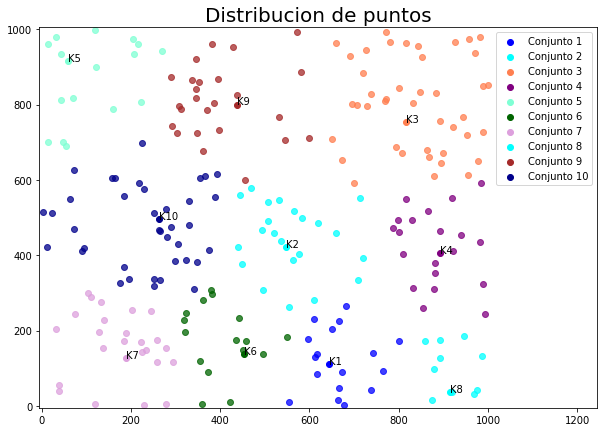

In [84]:
limX = (-5,1245)
limY = (-5,1005)
colors = colors[:rec.n_centros]
grafica = Graph1D(limX, limY, title="Distribucion de puntos", colors=colors)
idx = 0
for pts, color in zip(best, colors):
    idx+=1
    for i, p in enumerate(pts):
        if i == 0:  grafica.add_point((p.X,p.Y), color, "K"+str(idx), label="Conjunto "+str(idx))
        else:       grafica.add_point((p.X,p.Y), color)
grafica.setLegends()

In [87]:
bestValue

29185.279434974444